In [3]:
# ''' Do not change this cell '''
# #Functions

# def check_gpu():
#   if tf.test.gpu_device_name() != '':
#     print("GPU sucessfully connected")
#   else: print("PLease connect GPU")

# def check_data():
#   a = set()
#   for image in Images:
#     a.add(Image.shape[2])
#   if len(a)==1 and len(Images)==624:
#     print("PASS")
#   else: print("FAIL")

In [4]:
#Import any library here only.
import os
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

data_dir = '/content/drive/MyDrive/OpenCodeData'

images = []
labels = []

viral_count = 0
bacterial_count = 0

for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.jpeg'):
            img_path = os.path.join(root, filename)
            if 'virus' in filename:
                labels.append('VIRAL')
                viral_count += 1
            elif 'bacteria' in filename:
                labels.append('BACTERIAL')
                bacterial_count += 1
            else:
                labels.append('NORMAL')

            images.append(img_path)



count_normal = sum(1 for label in labels if label == 'NORMAL')
count_bacterial = sum(1 for label in labels if label == 'BACTERIAL' )
count_viral = sum(1 for label in labels if  label == 'VIRAL' )


print(f"Count of NORMAL images: {count_normal}")
print(f"Count of Bacterial images: {count_bacterial}")
print(f"Count of Viral images: {count_viral}")

Count of NORMAL images: 234
Count of Bacterial images: 242
Count of Viral images: 148


In [7]:
from PIL import Image, ImageEnhance

def augment_viral_images(images_list, labels_list, target_count):
    augmented_images = []
    augmented_labels = []
    count_viral = 0

    for img_path, label in zip(images_list, labels_list):
        img = Image.open(img_path)

        if label == 'VIRAL' and count_viral < target_count:
            rotated_images = [img.rotate(angle) for angle in [10, -10, 20, -20]]

            for rotated_img in rotated_images:
                augmented_images.append(rotated_img)
                augmented_labels.append(label)
                count_viral += 1

            if count_viral < target_count:
                flipped_image = img.transpose(Image.FLIP_LEFT_RIGHT)
                enhanced_image = ImageEnhance.Brightness(img).enhance(1.5)

                augmented_images.extend([flipped_image, enhanced_image])
                augmented_labels.extend([label, label])
                count_viral += 2

        else:
            augmented_images.append(img)
            augmented_labels.append(label)

    return augmented_images, augmented_labels

target_count_viral = min(count_normal, count_bacterial) - count_viral
augmented_images, augmented_labels = augment_viral_images(images, labels, target_count_viral)



In [8]:
count_normal_augmented = sum(1 for label in augmented_labels if label == 'NORMAL')
count_bacterial_augmented = sum(1 for label in augmented_labels if label == 'BACTERIAL')
count_viral_augmented = sum(1 for label in augmented_labels if label == 'VIRAL')

print(f"Count of Normal/Augmented images: {count_normal_augmented}")
print(f"Count of Bacterial/Augmented images: {count_bacterial_augmented}")
print(f"Count of Viral/Augmented images: {count_viral_augmented}")

Count of Normal/Augmented images: 234
Count of Bacterial/Augmented images: 242
Count of Viral/Augmented images: 221


In [9]:
from sklearn.model_selection import train_test_split

train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.3, random_state=42
)

test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42
)

print(f"Train set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")
print(f"Validation set size: {len(val_images)}")


Train set size: 487
Test set size: 105
Validation set size: 105


In [10]:
from PIL import Image
import numpy as np
def preprocess_images_resnet(image_list, target_size):
    processed_images = []
    for item in image_list:
        if isinstance(item, str):
            img_path = item
            img = Image.open(img_path).resize(target_size).convert('RGB')
        else:
            img = item.resize(target_size).convert('RGB')

        processed_images.append(np.array(img))

    return np.array(processed_images)

target_size_resnet = (224, 224)

train_images_resnet = preprocess_images_resnet(train_images, target_size_resnet)
train_images_resnet = train_images_resnet / 255.0

val_images_resnet = preprocess_images_resnet(val_images, target_size_resnet)
val_images_resnet = val_images_resnet / 255.0

test_images_resnet = preprocess_images_resnet(test_images, target_size_resnet)
test_images_resnet = test_images_resnet / 255.0



# train_labels_np = np.array(train_labels)
# val_labels_np = np.array(val_labels)
# test_labels_np = np.array(test_labels)

label_mapping = {'VIRAL': 1, 'BACTERIAL': 2, 'NORMAL': 0}

encoded_train_labels = np.array([label_mapping[label] for label in train_labels])
encoded_val_labels = np.array([label_mapping[label] for label in val_labels])
encoded_test_labels = np.array([label_mapping[label] for label in test_labels])

# train_images_np = np.expand_dims(train_images_np, axis=-1)
# val_images_np = np.expand_dims(val_images_np, axis=-1)
# test_images_np = np.expand_dims(test_images_np, axis=-1)

In [11]:
print("Shape of train_images_resnet:", train_images_resnet.shape)
print("Shape of val_images_resnet:", val_images_resnet.shape)
print("Shape of test_images_resnet:", test_images_resnet.shape)


Shape of train_images_resnet: (487, 224, 224, 3)
Shape of val_images_resnet: (105, 224, 224, 3)
Shape of test_images_resnet: (105, 224, 224, 3)


In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Change activation to softmax

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images_resnet, encoded_train_labels,
                    validation_data=(val_images_resnet, encoded_val_labels),
                    epochs=14, batch_size=32)

test_loss, test_acc = model.evaluate(test_images_resnet, encoded_test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')


Epoch 1/14
16/16 [==============================] - 8s 398ms/step - loss: 1.0392 - accuracy: 0.4456 - val_loss: 0.9486 - val_accuracy: 0.4952
Epoch 2/14
16/16 [==============================] - 3s 181ms/step - loss: 0.8935 - accuracy: 0.5893 - val_loss: 0.8394 - val_accuracy: 0.7333
Epoch 3/14
16/16 [==============================] - 3s 173ms/step - loss: 0.7711 - accuracy: 0.7351 - val_loss: 0.7672 - val_accuracy: 0.6952
Epoch 4/14
16/16 [==============================] - 3s 172ms/step - loss: 0.6988 - accuracy: 0.7474 - val_loss: 0.6924 - val_accuracy: 0.7810
Epoch 5/14
16/16 [==============================] - 3s 173ms/step - loss: 0.6165 - accuracy: 0.7885 - val_loss: 0.6684 - val_accuracy: 0.7619
Epoch 6/14
16/16 [==============================] - 3s 186ms/step - loss: 0.5571 - accuracy: 0.8193 - val_loss: 0.6021 - val_accuracy: 0.7905
Epoch 7/14
16/16 [==============================] - 3s 186ms/step - loss: 0.5241 - accuracy: 0.8501 - val_loss: 0.6028 - val_accuracy: 0.7714
Epoch 

4/4 [==============================] - 1s 123ms/step


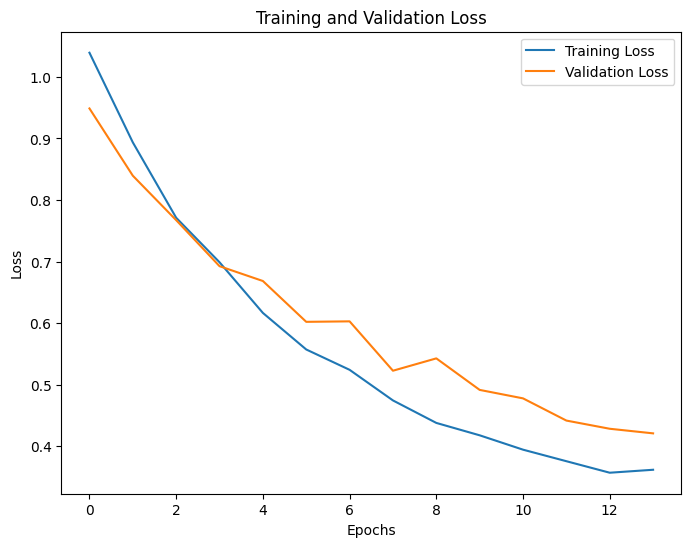

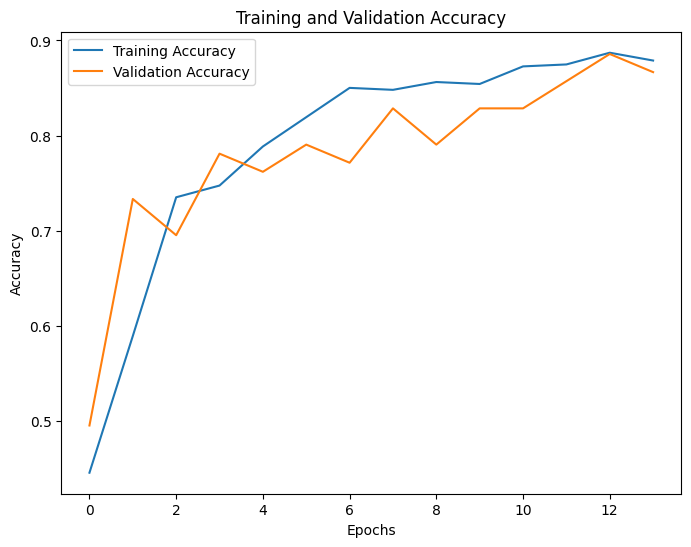

4/4 [==============================] - 0s 106ms/step - loss: 0.5178 - accuracy: 0.8190
Test accuracy: 81.90%


In [18]:
from sklearn.metrics import roc_auc_score

test_probs = model.predict(test_images_resnet)


from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.jpg')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_plot.jpg')
plt.show()


test_loss, test_acc = model.evaluate(test_images_resnet, encoded_test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')

In [19]:
model.save('vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
